In [1]:
%reset
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle as pk
import numpy as np
import matplotlib.pyplot as pl
import matplotlib
import torch

dev = torch.device("cuda")
# torch.cuda.set_device(dev)
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.distributions import Normal
# change the root directory for this notebook
root_dir = '/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/'
os.chdir(root_dir)

import sys, os
from nf.combined_models import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep import *
from tqdm import tqdm
%load_ext autoreload
%autoreload 2




Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
ji = 0
ns_d = 512
nb = 8
nax_d = ns_d // nb
nf = 3
layers_types = ['cnn', 'res', 'res']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

# z=127 is the initial condition
# z_all = [0, 0.5, 127]
z_all = [0, 127]
ns_h = 256
nax_h = ns_h // nb

nsims = 50


In [3]:
hidden_dim_MAF = 5
learning_rate = 0.01
K_M1 = 5
B_M1 = 3
nflows_M1_NSF = 5
K_Mdiff = 5
B_Mdiff = 3
nflows_Mdiff_NSF = 6
base_dist_M1 = 'gumbel'
base_dist_Mdiff = 'gumbel'
ngauss_M1 = 5
changelr = False
ksize = nf
nfeature_cnn = 4
nout_cnn = 4 * nfeature_cnn
ninp = len(z_all)
num_cond = nout_cnn + ninp



In [4]:
# Load the density data
df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train = load_density_halo_data(
    ji, ns_d, nb, nf, nc, z_all, ns_h
    )

# Prepare the density and halo data
return_dict_train = prep_density_halo_cats(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, nsims=nsims
    )




In [5]:
model_Ntot = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond,
    ngauss=return_dict_train['ngauss_Nhalo'],
    mu_all=return_dict_train['mu_all'],
    sig_all=return_dict_train['sig_all'],
    base_dist=None
    )
# model_Ntot.to(dev)

model_M1 = NSF_M1_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond + 1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    mu_pos=False
    )

# model_M1.to(dev)

ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'].shape[2]
model_Mdiff = NSF_Mdiff_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond + 2,
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )
# model_Mdiff.to(dev)

# print()



In [6]:
ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    model_Mdiff,
    # None,
    model_M1,
    model_Ntot,
    ndim,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Ntot_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    train_Ntot=True,
    train_M1=True,
    train_Mdiff=True
    )

model.to(dev)

print()




In [7]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_all_it = []
loss_min = 1e20


cond_tensor = torch.Tensor(np.copy(return_dict_train['df_d_all'])).cuda(dev)
# cond_tensor_nsh = torch.Tensor(np.copy(return_dict_train['df_d_all_nsh'].reshape(nsims * (nax_h ** 3), ninp))).cuda(dev)
cond_nsh = np.moveaxis(return_dict_train['df_d_all_nsh'], 1, 4)
print(cond_nsh.shape)
cond_tensor_nsh = torch.Tensor(np.copy(cond_nsh.reshape(nsims * (nax_h ** 3), ninp))).cuda(dev)
mask_tensor_M1_train = torch.Tensor(np.copy(return_dict_train['mask_M1'].reshape(nsims * (nax_h**3)))).cuda(dev)
mask_tensor_Mdiff_train = torch.Tensor((return_dict_train['mask_M_diff'].reshape(nsims * (nax_h**3),
                                                                                 ndim_diff))).cuda(dev)

X_M1 = torch.Tensor((return_dict_train['M1_halos_all_norm'].reshape(nsims * (nax_h**3), 1))).cuda(dev)
X_Nhalo = torch.Tensor(return_dict_train['Nhalo_train_mg_arr'].reshape(nsims * (nax_h**3), 1)).cuda(dev)
X_Mdiff = torch.Tensor(return_dict_train['M_diff_halos_all_norm_masked'].reshape(nsims * (nax_h**3),
                                                                                 ndim_diff)).cuda(dev)
Nhalos_truth_tensor = torch.Tensor(((return_dict_train['N_halos_all'].reshape(nsims * (nax_h**3), 1)))).cuda(dev)





(50, 32, 32, 32, 2)


In [8]:
print(nc)


5


In [9]:
save_bestfit_model_name = 'FINAL_COMBINED/model_save_ji' + str(ji) + '_nsd' + str(ns_d) + '_nb' + str(nb) + '_nf' + \
                str(nf) + '_nsh' + str(ns_h) + '_nsim' + str(nsims) + '_ncnn' + str(nc)

bestfit_model = (torch.load(save_bestfit_model_name))
model.load_state_dict(bestfit_model['state_dict'])
optimizer.load_state_dict(bestfit_model['optimizer'])



In [10]:
ninit = 0
niterations = 300
# torch.autograd.set_detect_anomaly(False)
for ito in tqdm(range(niterations)):
    optimizer.zero_grad()
    for g in optimizer.param_groups:
        g['lr'] = 0.01

    it = ito + ninit

    loss = model(
        X_Mdiff,
        X_M1,
        X_Nhalo,
        cond_x=cond_tensor,
        cond_x_nsh=cond_tensor_nsh,
        mask_Mdiff_truth=mask_tensor_Mdiff_train,
        mask_M1_truth=mask_tensor_M1_train,
        Nhalos_truth=Nhalos_truth_tensor,
        use_Ntot_samples=False,
        use_M1_samples=False
        )

    loss.backward()
    optimizer.step()

    if (np.mod(it, int(niterations / 30)) == 0) or (it == niterations - 1):
        if float(loss.cpu().detach().numpy()) < loss_min:
            loss_min = float(loss.cpu().detach().numpy())
            # print(loss1.detach().numpy(), loss2.detach().numpy(), loss3.detach().numpy())
            print('saving bf at:', ', with loss:', np.round(loss_min, 4))
            # print('saving bf at:', it, ', with loss:', np.round(loss_min, 9))
            state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}

            torch.save(
                state, save_bestfit_model_name
                )


            

  0%|          | 1/300 [00:02<14:00,  2.81s/it]

saving bf at: , with loss: -1.4961


  4%|▎         | 11/300 [00:12<04:31,  1.06it/s]

saving bf at: , with loss: -1.4968


  7%|▋         | 21/300 [00:21<04:17,  1.08it/s]

saving bf at: , with loss: -1.4971


 10%|█         | 31/300 [00:30<04:08,  1.08it/s]

saving bf at: , with loss: -1.4973


 14%|█▎        | 41/300 [00:39<03:59,  1.08it/s]

saving bf at: , with loss: -1.4975


 17%|█▋        | 51/300 [00:48<03:50,  1.08it/s]

saving bf at: , with loss: -1.4978


 20%|██        | 61/300 [00:57<03:40,  1.08it/s]

saving bf at: , with loss: -1.4979


 24%|██▎       | 71/300 [01:07<03:31,  1.08it/s]

saving bf at: , with loss: -1.498


 37%|███▋      | 111/300 [01:43<02:54,  1.08it/s]

saving bf at: , with loss: -1.498


 40%|████      | 121/300 [01:52<02:45,  1.08it/s]

saving bf at: , with loss: -1.4984


 57%|█████▋    | 171/300 [02:38<01:58,  1.08it/s]

saving bf at: , with loss: -1.4989


 90%|█████████ | 271/300 [04:10<00:26,  1.08it/s]

saving bf at: , with loss: -1.4992


100%|██████████| 300/300 [04:36<00:00,  1.08it/s]

saving bf at: , with loss: -1.5003


In [21]:
cond_tensor = cond_tensor.to(dev)
cond_tensor_nsh = cond_tensor_nsh.to(dev)
Ntot_samp, M1_samp, M_diff_samp, mask_tensor_M1_samp, mask_tensor_Mdiff_samp = model.inverse(
        cond_x=cond_tensor,
        cond_x_nsh=cond_tensor_nsh,
        use_truth_Nhalo=False,
            use_truth_M1=False,
            use_truth_Mdiff=False,    
            mask_Mdiff_truth=mask_tensor_Mdiff_train,
            mask_M1_truth=mask_tensor_M1_train,
            Nhalos_truth=X_Nhalo,
            M1_truth=X_M1
        )








Text(0, 0.5, 'Histogram')

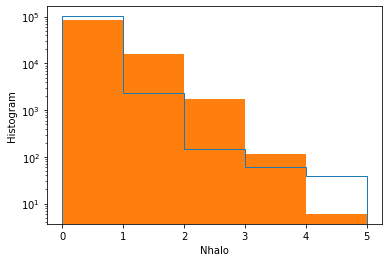

In [22]:
pl.figure()
indsel = np.where(cond_tensor_nsh.cpu().detach().numpy()[:,0] > 1.0)
_ = pl.hist(Ntot_samp[indsel], histtype='step', bins=[0,1,2,3,4,5])
_ = pl.hist(Nhalos_truth_tensor.cpu().detach().numpy()[indsel], bins=[0,1,2,3,4,5])
xarr = np.arange(9)
# yarr = 4e5*np.exp(-xarr)
al, bt = 0.0, 1.5
yarr = 4e5*np.power(1+xarr, al) * np.exp(-bt * xarr)
# yarr = 4e5/xarr**(5)
# pl.plot(xarr, yarr)
# _ = pl.hist(X_Nhalo[:,0].cpu().detach().numpy())
pl.yscale('log')
pl.xlabel('Nhalo')
pl.ylabel('Histogram')






Text(0, 0.5, 'Histogram')

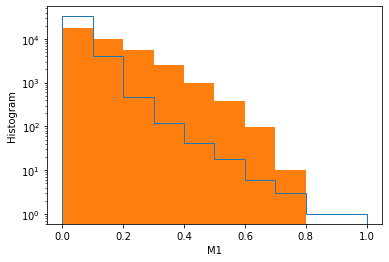

In [23]:
pl.figure()
indp = (mask_tensor_M1_samp.cpu().detach().numpy()[:,0] > 0)
_ = pl.hist(M1_samp.cpu().detach().numpy()[indp], range=(0,1), histtype='step')
indp = (mask_tensor_M1_train.cpu().detach().numpy() > 0)
_ = pl.hist(X_M1[:,0].cpu().detach().numpy()[indp], range=(0,1))
pl.yscale('log')
pl.xlabel('M1')
pl.ylabel('Histogram')








Text(0, 0.5, 'Histogram')

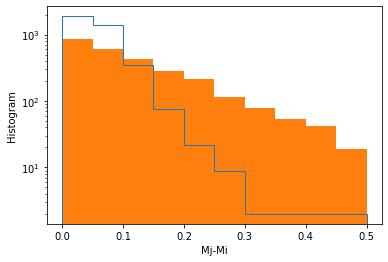

In [24]:
pl.figure()
ind_M = 0

indp = mask_tensor_Mdiff_samp[:, ind_M] > 0
_ = pl.hist(M_diff_samp[indp,ind_M].cpu().detach().numpy(), range=(0,0.5), histtype='step')
indp = mask_tensor_Mdiff_train[:, ind_M] > 0
_ = pl.hist(X_Mdiff[indp,ind_M].cpu().detach().numpy(), range=(0,0.5))


pl.yscale('log')
pl.xlabel(r'Mj-Mi')
pl.ylabel('Histogram')




